# Intro
En este notebook ya dejo presentado el modelo final a usar que luego ira a parar a .py _train.py_ y _predict.py_

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier, plot_importance
from joblib import dump
import shap
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    average_precision_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# Funciones

In [2]:
def get_train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    return X_train, X_test, y_train, y_test

def get_pos_weight(y_train):
    # Calculate class imbalance ratio
    neg, pos = np.bincount(y_train)
    scale_pos_weight = neg / pos
    print(f"Class ratio: {neg}:{pos}, scale_pos_weight = {scale_pos_weight:.2f}")
    
    return scale_pos_weight

In [3]:
def generate_train_test_report(name,model,params,X_train,X_test,y_train,y_test,cv):
    print(f"\n>>> Training {name} ...")

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=25,              
        cv=cv,
        n_jobs=-1,
        random_state=42,
        verbose=3
    )

    search.fit(X_train, y_train)


    # Evaluate best model
    best_model = search.best_estimator_
    best_parameter = search.best_params_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    metrics = {
        'model': name,
        'best_params': search.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'pr_auc': average_precision_score(y_test,y_prob)
    }

    print(f"Classification report for {name}:\n", classification_report(y_test, y_pred))
    
    return best_model,best_parameter,metrics

# Load

In [4]:
df_train = pd.read_csv("../data/raw/cs-training.csv")
X = df_train.drop(['SeriousDlqin2yrs','Unnamed: 0','age','NumberOfDependents','DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines'],axis = 1)
y = df_train['SeriousDlqin2yrs']

In [5]:
X_train, X_test, y_train, y_test = get_train_test(X,y)

# Train model

## Model initialization

In [6]:
model = XGBClassifier(
                eval_metric='logloss',
                random_state=42,
                scale_pos_weight=get_pos_weight(y_train)
                                        )

Class ratio: 111979:8021, scale_pos_weight = 13.96


## Hyperparameters

In [7]:
param_distributions = {
                'n_estimators': randint(100, 600),
                'max_depth': randint(3, 10),
                'learning_rate': uniform(0.01, 0.3),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4),
                'min_child_weight': randint(1, 10),
                'gamma': uniform(0, 5),
                'reg_lambda': uniform(0, 5),
                'reg_alpha': uniform(0, 5),
                'base_score': uniform(0.1,0.8)
            }

## Train setup

In [8]:
name = 'final_xgboost_model'
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_model,best_params,metrics = generate_train_test_report(name,model,param_distributions,X_train, X_test, y_train, y_test,cv)    


>>> Training final_xgboost_model ...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Classification report for final_xgboost_model:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87     27995
           1       0.20      0.78      0.32      2005

    accuracy                           0.78     30000
   macro avg       0.59      0.78      0.59     30000
weighted avg       0.93      0.78      0.83     30000



In [9]:
metrics

{'model': 'final_xgboost_model',
 'best_params': {'base_score': np.float64(0.6773836169318985),
  'colsample_bytree': np.float64(0.6943939678995823),
  'gamma': np.float64(1.2803416138066197),
  'learning_rate': np.float64(0.022130076861529402),
  'max_depth': 9,
  'min_child_weight': 3,
  'n_estimators': 162,
  'reg_alpha': np.float64(4.478817978367597),
  'reg_lambda': np.float64(2.3768511159105588),
  'subsample': np.float64(0.8253102287905535)},
 'accuracy': 0.7769666666666667,
 'precision': 0.1996153846153846,
 'recall': 0.7765586034912718,
 'f1': 0.3175930647628761,
 'roc_auc': 0.8551162101889409,
 'pr_auc': 0.39010256964691453}

In [11]:
explainer = shap.TreeExplainer(best_model,data=X_train)
shap_values = explainer.shap_values(X)

100%|===================| 149952/150000 [09:34<00:00]        

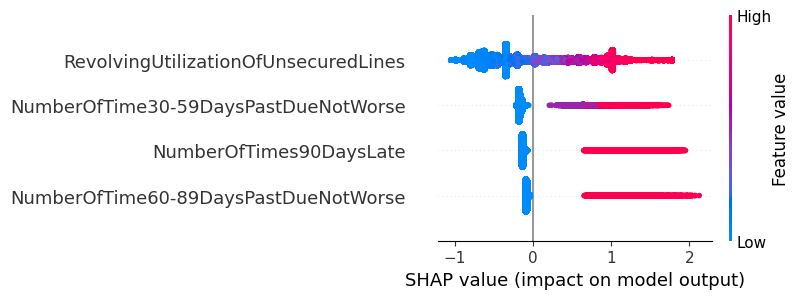

In [12]:
shap.summary_plot(shap_values, X)